# Modeling Distributions

The distributions we have used so far are called empirical distributions because they are based on empirical observations -- in other words, data. Many datasets we see in the real world can be closely approximated by a theoretical distribution, which is usually based on a simple mathematical model. This chapter presents some of these theoretical distributions and datasets they can be used to model.

As examples, we'll see that:

*    In a skeet shooting competition, the number of hits and misses is well modeled by a binomial distribution.

*    In games like hockey and soccer (football), the number of goals in a game follows a Poisson distribution, and the time between goals follows an exponential distribution.

*    Birth weights follow a normal distribution, also called a Gaussian, and adult weights follow a lognormal distribution.

If you are not familiar with these distributions -- or these sports -- I will explain what you need to know. For each example, we'll start with a simulation based on a simple model, and show that the simulation results follow an theoretical distribution. Then we'll see how well real data agrees with the model.

In [1]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/thinkstats.py")

<IPython.core.display.Javascript object>

In [3]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

<IPython.core.display.Javascript object>

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from thinkstats import decorate

<IPython.core.display.Javascript object>

## The Binomial Distribution

As a first example, we'll consider the sport of skeet shooting, in which competitors use shotguns to shoot clay disks that are thrown into the air.
In international competition, including the Olympics, there are five rounds with 25 targets per round, with additional rounds as needed to determine a winner.

As a model of a skeet-shooting competition, suppose that every participant has the same probability of hitting every target, `p`.
Of course, this model is a simplification -- in reality, it's likely that some competitors have a higher probability than others, and even for a single competitor, it might vary from one attempt to the next.
But even if it is not realistic, this model make some surprisingly accurate predictions, as we'll see.

To simulate the model, I'll use the following function, which takes the number of targets, `n`, and the probability of hitting each one, `p`, and returns a sequence of 1s and 0s to indicate hits and misses.

In [5]:
def flip(n, p):
    choices = [1, 0]
    probs = [p, 1 - p]
    return np.random.choice(choices, n, p=probs)

<IPython.core.display.Javascript object>

Here's an example that simulates a round of 25 targets where the probability of hitting each one is 90%.

In [6]:
flip(25, 0.9)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1])

<IPython.core.display.Javascript object>

If we generate a sequence of 1000 attempts, and compute the `Pmf` of the results, we can confirm that the proportions of 1s and 0s are correct, at least approximately.

In [7]:
from empiricaldist import Pmf

seq = flip(1000, 0.9)
pmf = Pmf.from_seq(seq)
pmf

,probs
0,0.103
1,0.897


<IPython.core.display.Javascript object>

Now we can use `flip` to simulate a round of skeet shooting and return the number of hits.

In [8]:
def simulate_round(n, p):
    seq = flip(n, p)
    return seq.sum()

<IPython.core.display.Javascript object>

In a large competition, suppose 200 competitors shoot 5 rounds each, all with the same probability of hitting the target, `p=0.9`.
We can simulate a competition like that by calling `simulate_round` 1000 times.

In [9]:
n = 25
p = 0.9
results_sim = [simulate_round(n, p) for i in range(1000)]

<IPython.core.display.Javascript object>

The average score is close to `22.5`, which is the product of `n` and `p`.

In [10]:
np.mean(results_sim), n * p

(22.476, 22.5)

<IPython.core.display.Javascript object>

Here's what the distribution of the results looks like.

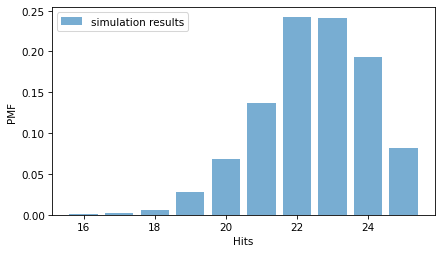

<IPython.core.display.Javascript object>

In [11]:
from empiricaldist import Pmf

pmf_sim = Pmf.from_seq(results_sim, name="simulation results")

pmf_sim.bar(alpha=0.6)
decorate(xlabel="Hits", ylabel="PMF")

Instead of running a simulation, we could have predicted this distribution.
Mathematically, we can show that the distribution of these outcomes follows a binomial distribution, which has a PMF that is easy to compute.

In [12]:
from scipy.special import comb


def binomial_pmf(k, n, p):
    """Compute the binomial PMF.

    k (int or array-like): number of successes
    n (int): number of trials
    p (float): probability of success on a single trial

    returns: float or ndarray
    """
    return comb(n, k) * (p**k) * ((1 - p) ** (n - k))

<IPython.core.display.Javascript object>

This function computes the probability of getting `k` hits out of `n` attempts, given `p`.
If we call this function with a range of `k` values, we can make a `Pmf` that represents the distribution of the outcomes.

In [13]:
ks = np.arange(16, n + 1)
ps = binomial_pmf(ks, n, p)
pmf_binom = Pmf(ps, ks, name="binomial model")

<IPython.core.display.Javascript object>

And here's what it looks like compared to the simulation results.

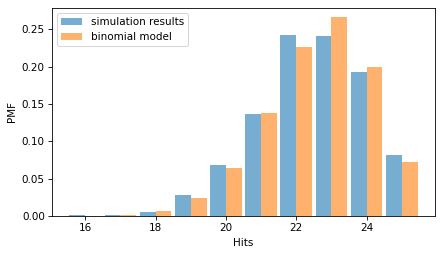

<IPython.core.display.Javascript object>

In [14]:
from thinkstats import two_bar_plots

two_bar_plots(pmf_sim, pmf_binom)
decorate(xlabel="Hits", ylabel="PMF")

They are similar, with small differences because of random variation in the simulation results.

This agreement should not be surprising, because the simulation and the model are based on the same assumptions -- particularly the assumption that every attempt has the same probability of success.
The real test of a model is how it compares to real data.

From the Wikipedia page for the men's skeet shooting competition at the 2020 Summer Olympics, we can extract a table that shows the results for the qualification rounds of the competition.

Downloaded from <https://en.wikipedia.org/wiki/Shooting_at_the_2020_Summer_Olympics_–_Men's_skeet> on July 15, 2024.

In [15]:
filename = "Shooting_at_the_2020_Summer_Olympics_–_Men's_skeet"
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/" + filename)

<IPython.core.display.Javascript object>

In [16]:
tables = pd.read_html("Shooting_at_the_2020_Summer_Olympics_–_Men's_skeet")
table = tables[6]
table.head()

,Rank,Athlete,Country,1,2,3,4,5,Total[3],Shoot-off,Notes
0,1,Éric Delaunay,France,25,25,25,24,25,124,+6,"Q, OR"
1,2,Tammaro Cassandro,Italy,24,25,25,25,25,124,+5,"Q, OR"
2,3,Eetu Kallioinen,Finland,25,25,24,25,24,123,NaN,Q
3,4,Vincent Hancock,United States,25,25,25,25,22,122,+8,Q
4,5,Abdullah Al-Rashidi,Kuwait,25,25,24,25,23,122,+7,Q


<IPython.core.display.Javascript object>

The table has one row for each competitors, with one column for each of five rounds.
We'll select the columns that contain the results and use `flatten` to put them into a single array.

In [17]:
columns = ["1", "2", "3", "4", "5"]
results = table[columns].values.flatten()

<IPython.core.display.Javascript object>

In [18]:
total_shots = 25 * len(results)
total_hits = results.sum()
n, total_shots, total_hits

(25, 3750, 3575)

<IPython.core.display.Javascript object>

With 30 competitors, we have results from 150 rounds of 25 shots each, with 3750 hits out of a total of 3575 attempts.
So the overall success rate is 95.3%.

In [19]:
p = total_hits / total_shots
p

0.9533333333333334

<IPython.core.display.Javascript object>

Now we can compute a `Pmf` that represents the binomial distribution with `n=25` and the value of `p` we just computed.

In [20]:
ps = binomial_pmf(ks, n, p)
pmf_binom = Pmf(ps, ks, name="binomial model")

<IPython.core.display.Javascript object>

And we can compare that to the `Pmf` of the actual results.

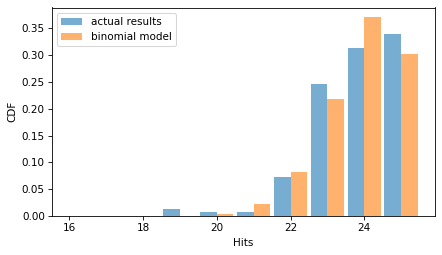

<IPython.core.display.Javascript object>

In [21]:
pmf_results = Pmf.from_seq(results, name="actual results")

two_bar_plots(pmf_results, pmf_binom)
decorate(xlabel="Hits", ylabel="CDF")

The binomial model is a good fit for the distribution of the data.

## The Poisson Distribution

As another example where the outcomes of sports events follow predictable patterns, let's look at the number of goals scored in ice hockey games.

We'll start by simulating a 60-minute game, which is 3600 seconds, assuming that the teams score a total of 6 goals per game, on average, and that the probability of scoring a goal is the same during any second.

In [22]:
n = 3600
m = 6
p = m / 3600
p

0.0016666666666666668

<IPython.core.display.Javascript object>

Now we can use the following function to simulate `n` seconds and return the total number of goals scored.

In [23]:
def simulate_goals(n, p):
    return flip(n, p).sum()

<IPython.core.display.Javascript object>

If we simulate 1000 games, we can confirm that the average number of goals per game is close to 6.

In [24]:
goals = [simulate_goals(n, p) for i in range(1000)]
np.mean(goals)

5.979

<IPython.core.display.Javascript object>

We could use the binomial distribution to model these results, but when `n` is large and `p` is small, the results are also well-modeled by a Poisson distribution, which has just one parameter, denoted with the Greek letter λ, which is pronounced "lambda" and represented in code with the variable `lam` (because `lambda` is a Python keyword).
`lam` represents the goal-scoring rate, which is 6 goals per game in the example.

The PMF of the Poisson distribution is easy to compute -- given `lam`, we can use the following function to compute the probability of seeing `k` goals in a game.

In [25]:
from scipy.special import factorial


def poisson_pmf(k, lam):
    """Compute the Poisson PMF.

    k (int or array-like): The number of occurrences
    lam (float): The rate parameter (λ) of the Poisson distribution

    returns: float or ndarray
    """
    return (lam**k) * np.exp(-lam) / factorial(k)

<IPython.core.display.Javascript object>

If we call this function with a range of `k` values, we can make a `Pmf` that represents the distribution of outcomes.

In [26]:
lam = 6
ks = np.arange(20)
ps = poisson_pmf(ks, lam)
pmf_poisson = Pmf(ps, ks, name="Poisson model")

<IPython.core.display.Javascript object>

And confirm that the mean of the distribution is close to 6.

In [27]:
pmf_poisson.normalize()
pmf_poisson.mean()

5.999925498375129

<IPython.core.display.Javascript object>

The following figure compares the results from the simulation to the Poisson distribution with the same mean.

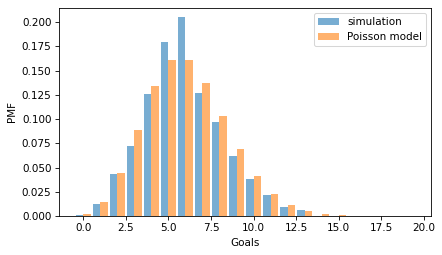

<IPython.core.display.Javascript object>

In [28]:
pmf_sim = Pmf.from_seq(goals, name="simulation")

two_bar_plots(pmf_sim, pmf_poisson)
decorate(xlabel="Goals", ylabel="PMF")

The distributions are similar except for small differences due to random variation.
That should not be surprising, because the simulation and the Poisson model are based on the same assumption, notably that the probability of scoring a goal is the same during any second of the game.
So the real test is to see how well the model fits real data.

From HockeyReference, I downloaded results of every game of the National Hockey League (NHL) 2023-2024 regular season (not including the playoffs).
I extracted information about goals scored during 60 minutes of regulation play, not including overtime or tie-breaking shootouts.
The results are in an HDF file with one key for each game, and a list of times, in seconds since the beginning of the game, when a goal was scored.

Raw data downloaded from <https://www.hockey-reference.com/leagues/NHL_2024_games.html> on July 16, 2024.

In [29]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/nhl_2023_2024.hdf")

<IPython.core.display.Javascript object>

Here's how we read the keys from the file.

In [30]:
filename = "nhl_2023_2024.hdf"

with pd.HDFStore(filename, "r") as store:
    keys = store.keys()

len(keys), keys[0]

(1312, '/202310100PIT')

<IPython.core.display.Javascript object>

There were 1312 games during the regular season.
Each key contains the date of the game and a three-letter abbreviation for the home team.
We can use `read_hdf` to look up a key and get the list of times when a goal was scored.

In [31]:
times = pd.read_hdf(filename, key=keys[0])
times

0     424
1    1916
2    2137
3    3005
4    3329
5    3513
dtype: int64

<IPython.core.display.Javascript object>

In the first game of the season, six goals were scored, the first after 424s second of play, the last at after 3513 seconds -- with only 87 seconds left in the game.

In [32]:
3600 - times[5]

87

<IPython.core.display.Javascript object>

The following loop reads the results for all games, counts the number of goals, and stores the result in a list.

In [33]:
goals = []

for key in keys:
    times = pd.read_hdf(filename, key=key)
    n = len(times)
    goals.append(n)

<IPython.core.display.Javascript object>

The average number of goals per game is just over 6.

In [34]:
lam = np.mean(goals)
lam

6.0182926829268295

<IPython.core.display.Javascript object>

We can use `poisson_pmf` to make a `Pmf` that represents a Poisson distribution with the same mean as the data.

In [35]:
ps = poisson_pmf(ks, lam)
pmf_poisson = Pmf(ps, ks, name="Poisson model")

<IPython.core.display.Javascript object>

And here's what it looks like compared to the PMF of the data.

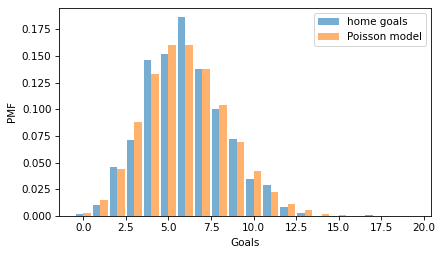

<IPython.core.display.Javascript object>

In [36]:
pmf_goals = Pmf.from_seq(goals, name="home goals")

two_bar_plots(pmf_goals, pmf_poisson)
decorate(xlabel="Goals", ylabel="PMF")

The data fit the Poisson model remarkably well.

## The Exponential Distribution

In the previous section, we simulated a simple model of a hockey game where a goal has the same probability of being scored during any second of the game.
Under the same model, it turns out, the times until the first goal follow an **exponential distribution**.

To demonstrate, let's assume again that the teams score a total of 6 goals, on average, and compute the probability of a goal during each second.

In [37]:
n = 3600
m = 6
p = m / 3600
p

0.0016666666666666668

<IPython.core.display.Javascript object>

The following function simulates `n` seconds and uses `argmax` to find the time of the first goal.

In [38]:
def simulate_first_goal(n, p):
    return flip(n, p).argmax()

<IPython.core.display.Javascript object>

This works because the result from `flip` is a sequence of 1s and 0s, so the maximum is almost always 1.
If there is at least one goal in the sequence, `argmax` returns the index of the first.
If there are no goals, it returns 0, but that happens seldom enough that we'll ignore it.

We'll use `simulate_first_goal` to simulate 1000 games and make a list of the times until the first goal.

In [39]:
first_goal_times = [simulate_first_goal(n, p) for i in range(1000)]
mean = np.mean(first_goal_times)
mean

579.764

<IPython.core.display.Javascript object>

The average time until the first goal is about 600 seconds, or 10 minutes.
And that makes sense -- if we expect 6 goals per game, we expect one goal every 10 minutes, on average.

When `n` is large and `p` is small, we can show mathematically that the expected time until the first goal follows an exponential distribution.

Because the simulation generates many unique time values, we'll use CDFs to compare distributions, rather than PMFs.
And the CDF of the exponential distribution is easy to compute.

In [40]:
def exponential_cdf(x, lam):
    """Compute the exponential CDF.

    x: float or sequence of floats
    lam: rate parameter

    returns: float or NumPy array of cumulative probability
    """
    return 1 - np.exp(-lam * x)

<IPython.core.display.Javascript object>

The parameter, `lam`, is the average number of events per unit of time -- in this example it is goals per second.
We can use the mean of the simulated results to compute lam.

In [41]:
lam = 1 / mean
lam

0.0017248397623860743

<IPython.core.display.Javascript object>

If we call this function with a range of time values, we can approximate the distribution of first goal times.

In [42]:
from empiricaldist import Cdf

ts = np.linspace(0, 3600, 201)
ps = exponential_cdf(ts, lam)
cdf_expo = Cdf(ps, ts, name="exponential model")

<IPython.core.display.Javascript object>

The following figure compares the simulation results to the exponential distribution we just computed.

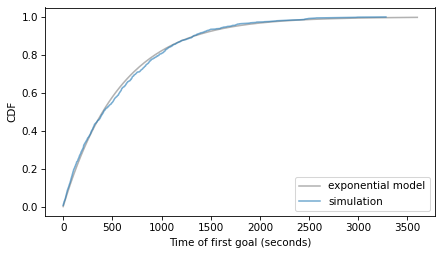

<IPython.core.display.Javascript object>

In [43]:
cdf_sim = Cdf.from_seq(first_goal_times, name="simulation")

cdf_expo.plot(alpha=0.6, color="gray")
cdf_sim.plot(alpha=0.6)

decorate(xlabel="Time of first goal (seconds)", ylabel="CDF")

The exponential model fits the results from the simulation very well -- but the real test is to see how it does with real data.

The following loop reads the results for all games, gets the time of the first goal, and stores the result in a list.
If no goals were scored, it adds `nan` to the list.

In [44]:
filename = "nhl_2023_2024.hdf"

with pd.HDFStore(filename, "r") as store:
    keys = store.keys()

<IPython.core.display.Javascript object>

In [45]:
firsts = []

for key in keys:
    times = pd.read_hdf(filename, key=key)
    if len(times) > 0:
        firsts.append(times[0])
    else:
        firsts.append(np.nan)

<IPython.core.display.Javascript object>

To estimate the goal-scoring rate, we can use `nanmean`, which computes the mean of the times, ignoring `nan` values.

In [46]:
lam = 1 / np.nanmean(firsts)
lam

0.0015121567467720825

<IPython.core.display.Javascript object>

Now we can compute the CDF of an exponential distribution with the same goal-scoring rate as the data.

In [47]:
ps = exponential_cdf(ts, lam)
cdf_expo = Cdf(ps, ts, name="exponential model")

<IPython.core.display.Javascript object>

To compute the CDF of the data, we'll use the `dropna=False` argument, which includes `nan` values at the end.

In [48]:
cdf_firsts = Cdf.from_seq(firsts, name="data", dropna=False)
cdf_firsts.tail()

,probs
3286.0,0.996951
3581.0,0.997713
NaN,1.000000


<IPython.core.display.Javascript object>

The following figure compares the exponential distribution to the distribution of the data.

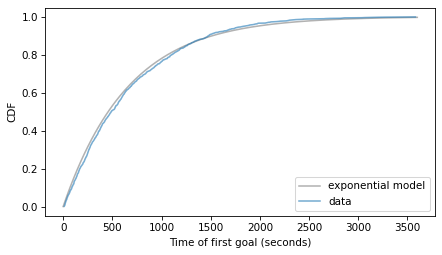

<IPython.core.display.Javascript object>

In [49]:
cdf_expo.plot(alpha=0.6, color="gray")
cdf_firsts.plot(alpha=0.6)

decorate(xlabel="Time of first goal (seconds)", ylabel="CDF")

The data deviate from the model in some places -- it looks like there are fewer goals in the first 1000 seconds than the model predicts.
But still, the model fits the data well.

The underlying assumption of these models -- the Poisson model of goals and the exponential model of times -- is that a goal is equally likely during any second of a game.
If you ask a hockey fan whether that's true, they would say no, and they would be right -- the real world violates assumptions like these in many ways.
But despite these violations, theoretical distributions often fit real data remarkably well.

## The Normal Distribution

Many things we measure in the real world follow a normal distribution, also known as a Gaussian distribution or a "bell curve".
To see where these distributions come from, let's consider a model of the way giant pumpkins grow.
Suppose that each day, a pumpkin gains 1 pound if the weather is bad, 2 pounds if the weather is fair, and 3 pounds if the weather is good.
And suppose the weather each day is bad, fair, or good with the same probability.

We can use the following function to simulate this model for `n` days and return the total of the weight gains.

In [50]:
def simulate_growth(n):
    choices = [1, 2, 3]
    gains = np.random.choice(choices, n)
    return gains.sum()

<IPython.core.display.Javascript object>

Now suppose 1001 people grow giant pumpkins in different places with different weather.
If we simulate the growth process for 100 days, we get a list of 1001 weights.

In [51]:
sim_weights = [simulate_growth(100) for i in range(1001)]
m, s = np.mean(sim_weights), np.std(sim_weights)
m, s

(199.65534465534466, 8.193592554377279)

<IPython.core.display.Javascript object>

The mean is close to 200 and the standard deviation is about 8.
To see whether the weights follow a normal distribution, we'll use the following function, which takes a sample and makes a `Cdf` that represents a normal distribution with the same mean and standard deviation of the sample, evaluated over the range of the sample. 

In [52]:
from scipy.stats import norm


def make_normal_model(data):
    """Make the Cdf of a normal distribution based on data.

    data: sequence of numbers
    """
    m, s = np.mean(data), np.std(data)
    low, high = m - 4 * s, m + 4 * s
    qs = np.linspace(low, high, 201)
    ps = norm.cdf(qs, m, s)
    return Cdf(ps, qs, name="normal model")

<IPython.core.display.Javascript object>

Here's how we use it.

In [53]:
cdf_model = make_normal_model(sim_weights)

<IPython.core.display.Javascript object>

Now we can make a `Cdf` that represents the distribution of the simulation results.

In [54]:
cdf_sim_weights = Cdf.from_seq(sim_weights, name="simulation")

<IPython.core.display.Javascript object>

We'll use the following function to compare the distributions.

In [55]:
def two_cdf_plots(cdf_model, cdf_data, xlabel="", **options):
    """Plot an empirical CDF and a theoretical model.

    cdf_model: Cdf object
    cdf_data: Cdf object
    xlabel: string
    options: control the way cdf_data is plotted
    """
    cdf_model.plot(alpha=0.6, color="gray")
    cdf_data.plot(alpha=0.6, **options)

    decorate(xlabel=xlabel, ylabel="CDF")

<IPython.core.display.Javascript object>

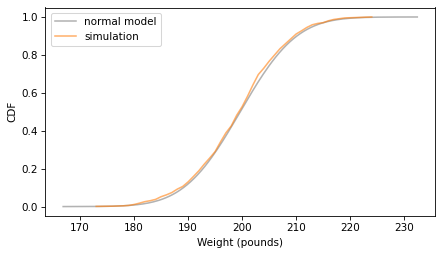

<IPython.core.display.Javascript object>

In [56]:
two_cdf_plots(cdf_model, cdf_sim_weights, color="C1", xlabel="Weight (pounds)")

The normal model fits the distribution of the weights pretty well.
In general, when we add up random factors, the sum tends to follow a normal distribution.
That's a consequence of the Central Limit Theorem, which we'll come back to in Chapter xxx.

But first let's see how well the normal distribution fits real data.
As an example, we'll look at the distribution of birth weights in the National Survey of Family Growth (NSFG).
We can use `read_fem_preg` to read the data, then select the `totalwgt_lb` column, which records birth weights in pounds.

In [57]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemPreg.dct")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemPreg.dat.gz")

<IPython.core.display.Javascript object>

In [58]:
import nsfg

preg = nsfg.read_fem_preg()
birth_weights = preg["totalwgt_lb"].dropna()

<IPython.core.display.Javascript object>

The average of the birth weights is about 7.27 pounds, and the standard deviation is 1.4 pounds, but as we've seen, there are some outliers in this dataset that are probably errors.

In [59]:
m, s = np.mean(birth_weights), np.std(birth_weights)
m, s

(7.265628457623368, 1.40821553384062)

<IPython.core.display.Javascript object>

To reduce the effect of the outliers on the estimated mean and standard deviation, we'll use the SciPy function `trimboth` to remove the highest and lowest values.

In [60]:
from scipy.stats import trimboth

trimmed = trimboth(birth_weights, 0.01)
m, s = np.mean(trimmed), np.std(trimmed)
m, s

(7.280883100022579, 1.2430657948614345)

<IPython.core.display.Javascript object>

With the trimmed data, the mean is a little lower and the standard deviation is substantially lower.
We'll use the trimmed data to make a normal model.

In [61]:
cdf_model = make_normal_model(trimmed)

<IPython.core.display.Javascript object>

And compare it to the `Cdf` of the data.

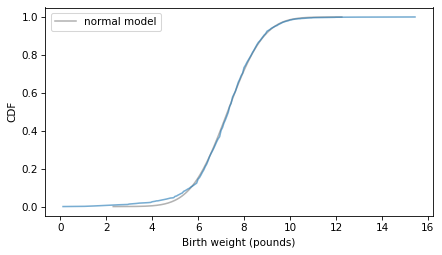

<IPython.core.display.Javascript object>

In [62]:
cdf_birth_weight = Cdf.from_seq(birth_weights)

two_cdf_plots(cdf_model, cdf_birth_weight, xlabel="Birth weight (pounds)")

The normal model fits the data well except in the range of the lightest babies.

## The Lognormal Distribution

In the previous section, we simulated pumpkin growth under the assumption that pumpkins grow 1-3 pounds per day, depending on the weather.
Instead, let's suppose their growth is proportional to their current weight, so big pumpkins gain more weight per day than small pumpkins -- which is probably more realistic.

The following function simulates this kind of proportionate growth, where a pumpkin gains 3% of its weight if the weather is bad, 5% if the weather is fair, and 7% if the weather is good.
Again, we'll assume that the weather is bad, fair, or good on any given day with equal probability.

In [63]:
def simulate_proportionate_growth(n):
    choices = [1.03, 1.05, 1.07]
    gains = np.random.choice(choices, n)
    return gains.prod()

<IPython.core.display.Javascript object>

If a pumpkin gains 3% of its weight, the final weight is the product of the initial weight and the factor 1.03.
So we can compute the weight after 100 days by choosing random factors and multiplying them together.

We can call this function 1000 times to simulate 1000 pumpkins and save their weights.

In [64]:
sim_weights = [simulate_proportionate_growth(100) for i in range(1000)]
np.mean(sim_weights), np.std(sim_weights)

(131.85385724763375, 19.9744029082836)

<IPython.core.display.Javascript object>

The average weight is about 132 pounds; the standard deviation is about 20 pounds.
So the pumpkins in this model are smaller but more variable than in the previous model.

And we can show mathematically that they follow a lognormal distribution.
In the proportionate growth model, the final weight is the product of an initial weight and 100 random factors, which we can write like this:

$$ w_n = w_0 \cdot f_1 \cdot f_2 \cdot \dots \cdot f_n $$ 

where $w_0$ is the initial weight, $w_n$ is the final weight after $n$ steps, and $f_i$ is a random multiplicative factor at step $i$.
If we take the log of both sides of this equation, the log of the product is the sum of the logs:

$$ \log w_n = \log w_0 + \log f_1 + \log f_2 + \dots + \log f_n $$ 

So the logarithm of each weight is the sum of a sequence of random terms, which we expect to follow a normal distribution, according to the Central Limit Theorem.
And if the logarithms of the weights follow a normal distribution, we'd say that the weights themselves follow a **lognormal distribution**.

To check, we'll compute the logs of the weights.
We could use logarithms with any base, but I'll use base 10 because it makes the results easier to interpret.

In [65]:
log_sim_weights = np.log10(sim_weights)
m, s = np.mean(log_sim_weights), np.std(log_sim_weights)
m, s

(2.115181401026853, 0.06528342827152227)

<IPython.core.display.Javascript object>

Now let's compare the distribution of the logarithms to a normal distribution with the same mean and standard deviation.



In [66]:
cdf_model = make_normal_model(log_sim_weights)

<IPython.core.display.Javascript object>

In [67]:
cdf_log_sim_weights = Cdf.from_seq(log_sim_weights, name="simulation")

<IPython.core.display.Javascript object>

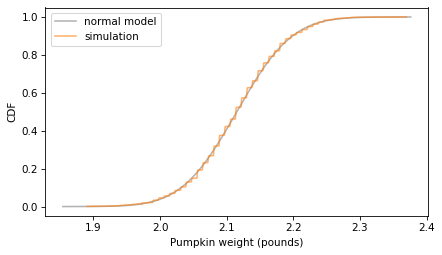

<IPython.core.display.Javascript object>

In [68]:
two_cdf_plots(
    cdf_model, cdf_log_sim_weights, color="C1", xlabel="Pumpkin weight (pounds)"
)

If people are like pumpkins, where the change in weight from year to year is proportionate to current weight, we might expect the distribution of adult weights to follow a lognormal distribution.
Let's find out.

The National Center for Chronic Disease Prevention and Health Promotion conducts an annual survey as part of the Behavioral Risk Factor Surveillance System (BRFSS).[^3] In 2008, they interviewed 414,509 respondents and asked about their demographics, health, and health risks.
Among the data they collected are the weights in kilograms of 398,484 respondents.

The `thinkstats` module provides a function that reads data from the BRFSS and returns a Pandas `DataFrame`.

In [69]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/CDBRFS08.ASC.gz")

<IPython.core.display.Javascript object>

In [70]:
from thinkstats import read_brfss

brfss = read_brfss()

<IPython.core.display.Javascript object>

Adult weights in kilograms are recorded in the `wtkg2` column.

In [71]:
adult_weights = brfss["wtkg2"].dropna()
m, s = np.mean(adult_weights), np.std(adult_weights)
m, s

(78.9924529968581, 19.546132387397257)

<IPython.core.display.Javascript object>

The mean is about 79 kg.
Before we compute logarithms, let's see if the weights follow a normal distribution.

In [72]:
cdf_model = make_normal_model(adult_weights)

<IPython.core.display.Javascript object>

In [73]:
cdf_adult_weights = Cdf.from_seq(adult_weights, name="adult weight")

<IPython.core.display.Javascript object>

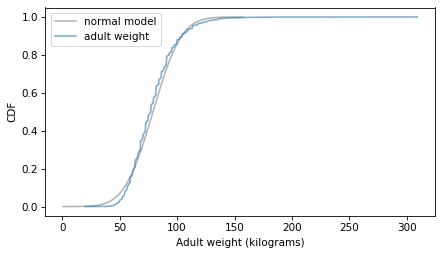

<IPython.core.display.Javascript object>

In [74]:
two_cdf_plots(cdf_model, cdf_adult_weights, xlabel="Adult weight (kilograms)")

The normal distribution is not a terrible model for the data, and might be good enough for some purposes -- but let's see if we can do better.

Here's the distribution of the log-transformed weights and a normal model with the same mean and standard deviation.

In [75]:
log_adult_weights = np.log10(adult_weights)

<IPython.core.display.Javascript object>

In [76]:
cdf_model = make_normal_model(log_adult_weights)

<IPython.core.display.Javascript object>

In [77]:
cdf_log_adult_weights = Cdf.from_seq(log_adult_weights, name="log adult weight")

<IPython.core.display.Javascript object>

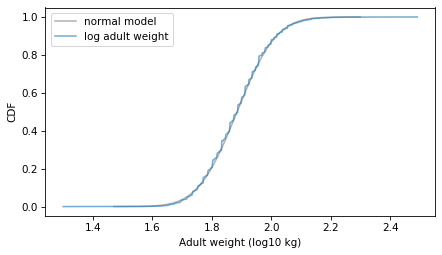

<IPython.core.display.Javascript object>

In [78]:
two_cdf_plots(cdf_model, cdf_log_adult_weights, xlabel="Adult weight (log10 kg)")

The normal model fits the logarithms better than it fits the weights themselves, which suggests that the weights follow a lognormal model.

## Why model?

At the beginning of this chapter, I said that many real world phenomena can be modeled with theoretical distributions.
But it might not have been clear why we should care.

Like all models, theoretical distributions are abstractions, which means they leave out details that are considered irrelevant.
For example, an observed distribution might have measurement errors or quirks that are specific to the sample; theoretical models smooth out these idiosyncrasies.

Theoretical models are also a form of data compression.
When a model fits a dataset well, a small set of parameters can summarize a large amount of data.

It is sometimes surprising when data from a natural phenomenon fit an theoretical distribution, but these observations can provide insight into physical systems.
Sometimes we can explain why an observed distribution has a particular form.

For example, 

Also, theoretical distributions lend themselves to mathematical analysis, as we will see in Chapter [\[analysis\]](#analysis){reference-type="ref" reference="analysis"}.

But it is important to remember that all models are imperfect.
Data from the real world never fit an theoretical distribution perfectly.
People sometimes talk as if data are generated by models; for example, they might say that the distribution of human heights is normal, or the distribution of income is lognormal.
Taken literally, these claims cannot be true -- there are always differences between the real world and mathematical models.

Models are useful if they capture the relevant aspects of the real world and leave out unneeded details.
But what is "relevant" or "unneeded" depends on what you are planning to use the model for.

## Exercises

### Exercise

In the NSFG respondent file, the `numfmhh` column records the "number of family members in" each respondent's household.
We can use `read_fem_resp` to read the file, and `query` to select respondents who were 25 or older when they were interviewed.

In [79]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemResp.dct")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemResp.dat.gz")

<IPython.core.display.Javascript object>

In [80]:
from nsfg import read_fem_resp

resp = read_fem_resp()

<IPython.core.display.Javascript object>

In [81]:
older = resp.query("age >= 25")
num_family = older["numfmhh"]

<IPython.core.display.Javascript object>

Compute the `Pmf` of `numfmhh` for these older respondents and compare it with a Poisson distribution with the same mean.
How well does the Poisson model fit the data?

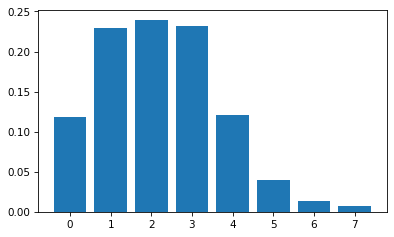

<IPython.core.display.Javascript object>

In [82]:
# Solution

pmf_family = Pmf.from_seq(num_family, name="data")
pmf_family.bar()

In [83]:
# Solution

lam = num_family.mean()
lam

2.2177890229661346

<IPython.core.display.Javascript object>

In [84]:
# Solution

high = np.max(num_family)
ks = np.arange(high + 1)
ps = poisson_pmf(ks, lam)
pmf_poisson = Pmf(ps, ks, name="Poisson model")

<IPython.core.display.Javascript object>

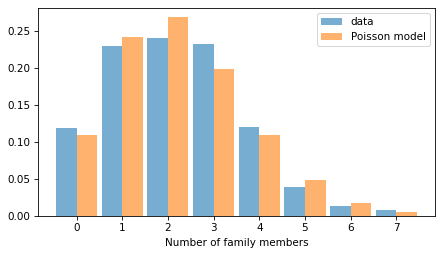

<IPython.core.display.Javascript object>

In [85]:
# Solution

two_bar_plots(pmf_family, pmf_poisson)
decorate(xlabel="Number of family members")

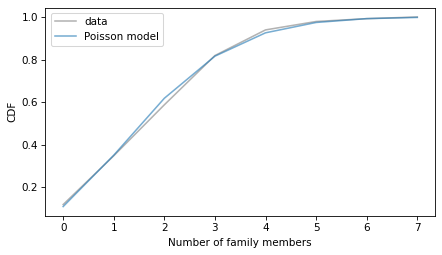

<IPython.core.display.Javascript object>

In [86]:
# Solution

two_cdf_plots(pmf_family.make_cdf(), pmf_poisson.make_cdf())
decorate(xlabel="Number of family members")

In [87]:
# Solution

# The Poisson model fits the data quite well, which is
# surprising because there's no obvious reason it should!

<IPython.core.display.Javascript object>

### Exercise

In Section xxx, we saw that the time until the first goal in a hockey game follows an exponential distribution.
If our model of goal-scoring is correct, a goal is equally likely at any time, regardless of how long it has been since the previous goal.
And if that's true, we expect the time between goals to follow an exponential distribution.

The following loop reads the hockey data, computes the time between successive goals, if there is more than one in a game, and collects the inter-goal times in a list.

In [88]:
filename = "nhl_2023_2024.hdf"

with pd.HDFStore(filename, "r") as store:
    keys = store.keys()

<IPython.core.display.Javascript object>

In [89]:
times = pd.read_hdf(filename, key=keys[0])
times

0     424
1    1916
2    2137
3    3005
4    3329
5    3513
dtype: int64

<IPython.core.display.Javascript object>

In [90]:
times.diff()

0       NaN
1    1492.0
2     221.0
3     868.0
4     324.0
5     184.0
dtype: float64

<IPython.core.display.Javascript object>

In [91]:
intervals = []

for key in keys:
    times = pd.read_hdf(filename, key=key)
    if len(times) > 1:
        intervals.extend(times.diff().dropna())

<IPython.core.display.Javascript object>

Use `exponential_cdf` to compute the CDF of an exponential distribution with the same mean as the observed intervals and compare this model to the CDF of the data.

In [92]:
# Solution

lam = 1 / np.mean(intervals)
lam

0.002040836560191201

<IPython.core.display.Javascript object>

In [93]:
# Solution

ts = np.linspace(0, np.max(intervals), 201)
ps = exponential_cdf(ts, lam)
cdf_expo = Cdf(ps, ts, name="exponential model")

<IPython.core.display.Javascript object>

In [94]:
# Solution

cdf_intervals = Cdf.from_seq(intervals, name="data", dropna=False)

<IPython.core.display.Javascript object>

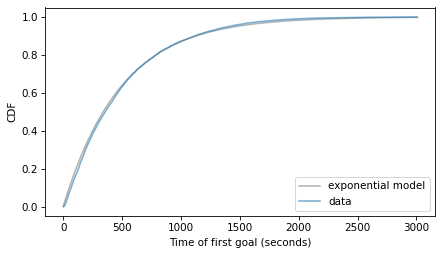

<IPython.core.display.Javascript object>

In [95]:
# Solution

cdf_expo.plot(alpha=0.6, color="gray")
cdf_intervals.plot(alpha=0.6)

decorate(xlabel="Time of first goal (seconds)", ylabel="CDF")

### Exercise

Is the distribution of human height more like a normal or a lognormal distribution?
To find out, we can select height data from the BRFSS like this:

In [96]:
adult_heights = brfss["htm3"].dropna()
m, s = np.mean(adult_heights), np.std(adult_heights)
m, s

(168.82518961012298, 10.35264015645592)

<IPython.core.display.Javascript object>

Compute the CDF of these values and compare it to a normal distribution with the same mean and standard deviation.
Then compute the logarithms of the heights and compute the distribution of the logarithms to a normal distribution.
Which model fits the data better?

In [97]:
# Solution

cdf_adult_heights = Cdf.from_seq(adult_heights, name="data")

<IPython.core.display.Javascript object>

In [98]:
# Solution

cdf_model = make_normal_model(adult_heights)

<IPython.core.display.Javascript object>

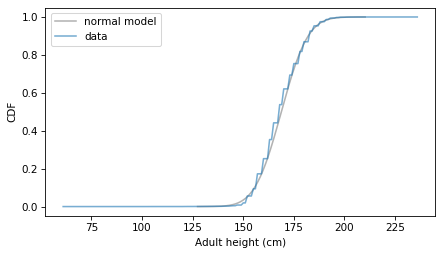

<IPython.core.display.Javascript object>

In [99]:
# Solution

two_cdf_plots(cdf_model, cdf_adult_heights, xlabel="Adult height (cm)")

In [100]:
# Solution

log_adult_heights = np.log10(adult_heights)
cdf_model = make_normal_model(log_adult_heights)
cdf_log_adult_heights = Cdf.from_seq(log_adult_heights, name="data")

<IPython.core.display.Javascript object>

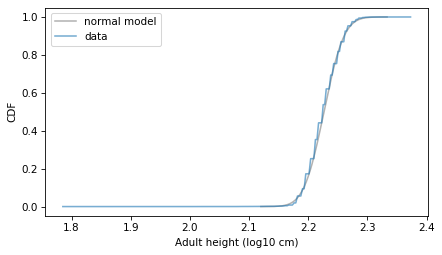

<IPython.core.display.Javascript object>

In [101]:
# Solution

two_cdf_plots(cdf_model, cdf_log_adult_heights, xlabel="Adult height (log10 cm)")